### Library Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

import visuals as vs

from imblearn.over_sampling import SMOTE
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 90)


### Data Loading

In [2]:
df = pd.read_csv('credit_messy.csv')

In [3]:
df.columns

Index(['ID', 'CreditLimit', 'Gender', 'Education', 'MaritalStatus', 'Age',
       'RepayStatApr', 'RepayStatMay', 'RepayStatJun', 'RepayStatJul',
       'RepayStatAug', 'RepayStatSep', 'BillSep', 'BillAug', 'BillJul',
       'BillJun', 'BillMay', 'BillApr', 'PaymentSep', 'PaymentAug',
       'PaymentJul', 'PaymentJun', 'PaymentMay', 'PaymentApr', 'Default'],
      dtype='object')

In [4]:
df.head()

,ID,CreditLimit,Gender,Education,MaritalStatus,Age,RepayStatApr,RepayStatMay,RepayStatJun,RepayStatJul,RepayStatAug,RepayStatSep,BillSep,BillAug,BillJul,BillJun,BillMay,BillApr,PaymentSep,PaymentAug,PaymentJul,PaymentJun,PaymentMay,PaymentApr,Default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Initial data exploration 

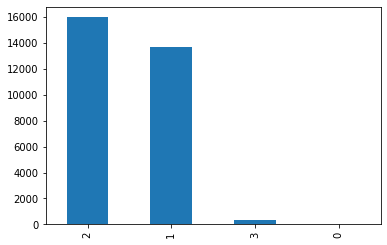

In [5]:
df.MaritalStatus.value_counts().plot(kind='bar')

In [6]:
df.MaritalStatus.value_counts()

2    15964
1    13659
3      323
0       54
Name: MaritalStatus, dtype: int64

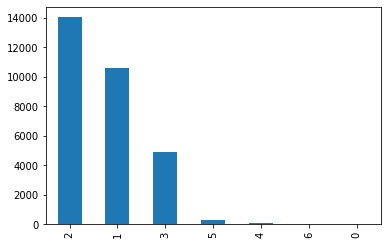

In [7]:
df.Education.value_counts().plot(kind='bar')

In [8]:
df.Education.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: Education, dtype: int64

In [9]:
# Either mislabelled or incorrect data (marriage = 0, Education = 0)
# Given this is such a small proportion of our set, i've decided to drop the rows containing this information

to_drop = (df.loc[(df.Education > 4 )|(df.Education == 0) ]).index
to_drop_again = (df.loc[df.MaritalStatus == 0]).index
df = df.drop(to_drop)
df = df.drop(to_drop_again)

In [10]:
df.columns =['ID','CreditLimit','Gender','Education','MaritalStatus','Age',
        'RepayStatApr','RepayStatMay','RepayStatJun','RepayStatJul','RepayStatAug','RepayStatSep',
        'BillApr','BillMay','BillJun','BillJul','BillAug','BillSep',
        'PrevPaymentApr','PrevPaymentMay','PrevPaymentJun','PrevPaymentJul','PrevPaymentAug','PrevPaymentSep',
        'Default']



### Getting a feel for the distribution of the data to analyse points for feature engineering

The following cell will help us interpret our EDA by mapping the categorical variables based on the columns values

In [11]:
gender_dict ={1:'male', 2:'female'}
education_dict = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'}
marriage_dict = {1 : 'married', 2 : 'single', 3 : 'others'}
df['Gender'] = df['Gender'].map(gender_dict)
df['Education'] = df['Education'].map(education_dict)
df['MaritalStatus'] = df['MaritalStatus'].map(marriage_dict)

Converting .describe into USD for interpretation

In [13]:
for result in df['CreditLimit'].describe():
    print('$' + str(round(result*0.033, 2)))

$976.83
$5529.17
$4288.15
$330.0
$1650.0
$4620.0
$7920.0
$33000.0


In [44]:
avg_credit_limit = df['CreditLimit'].mean()
print('Average Credit Limit: $', round(avg_credit_limit), 2)

total_default_pcnt = df['Default'].sum()/len(df.Default)
print('Average Chance of Default: ',round((total_default_pcnt * 100), 3), '%')

Average Credit Limit: $ 167551 2
Average Chance of Default:  22.313 %


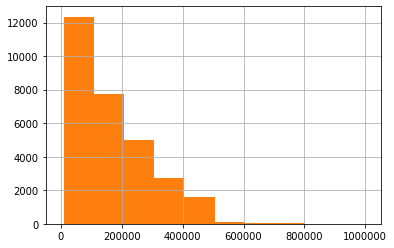

In [26]:
vs.hists(df,'Age')
vs.hists(df, 'CreditLimit')

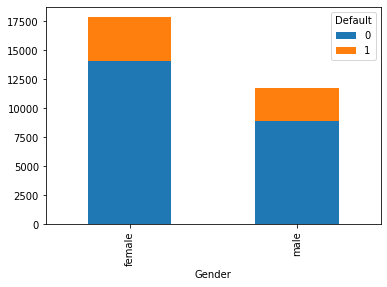

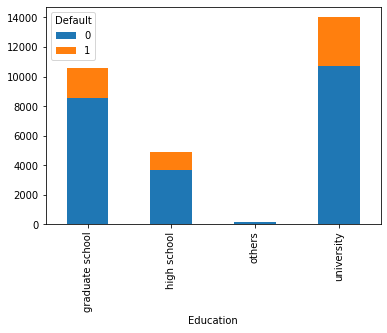

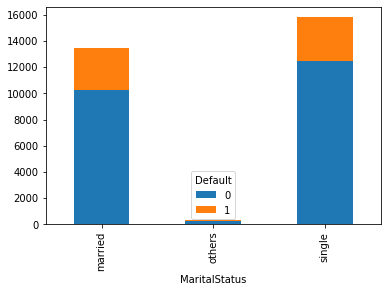

In [19]:
vs.bars(df,'Gender')
vs.bars(df,'Education')
vs.bars(df,'MaritalStatus')

In [ ]:
gender_df['percentage_defaulted'] = round((gender_df[1]/(gender_df[0] + gender_df[1]))*100, 3)
gender_df

In [ ]:
education_df = pd.DataFrame(df.groupby(['Education', 'Default']).size().unstack())                            
education_df

In [ ]:
education_df['percentage_defaulted'] = round((education_df[1]/(education_df[0] + education_df[1]))*100, 3)
education_df

In [ ]:
marriage_df = pd.DataFrame(df.groupby(['MaritalStatus', 'Default']).size().unstack())
marriage_df.plot(kind='bar', stacked = True)

In [ ]:
marriage_df['percentage_defaulted'] = round((marriage_df[1]/(marriage_df[0] + marriage_df[1]))*100, 3)
marriage_df

In [ ]:
g = sns.FacetGrid(df, col='Gender', hue='Default')
g.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
g.add_legend()

In [ ]:
e = sns.FacetGrid(df, col='Education', hue='Default')
e.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
e.add_legend()

In [ ]:
m = sns.FacetGrid(df, col='MaritalStatus', hue='Default')
m.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
m.add_legend()

In [ ]:
df['average_bill'] =  (df['BillApr'] + df['BillMay'] + df['BillJun'] + df['BillJul'] + df['BillAug'] + df['BillSep'])/6                                                                           
df['average_payment'] = (df['PrevPaymentSep']  + df['PrevPaymentAug'] + df['PrevPaymentJul'] + df['PrevPaymentJun'] + df['PrevPaymentMay'] + df['PrevPaymentApr'])/6
df['total_payment'] = (df['PrevPaymentSep'] + df['PrevPaymentAug'] + df['PrevPaymentJul'] + df['PrevPaymentJun'] + df['PrevPaymentMay'] + df['PrevPaymentApr'])                                                                                  
df['average_percentage_of_bill_paid'] = (df['average_payment']/df['average_bill'])*100
df['bill_paid/credit_limit'] = (df['total_payment']/df['CreditLimit'])*100
df['average_bill_paid/credit_limit'] = (df['average_payment']/df['CreditLimit'])*100

In [ ]:
# From this step above we found 784 cases of users who had 0 total bill, and 0 payments.
# Given they were not using the cards, and there was a range of defaults and non defaults, we decided to remove this data as we were unsure on how someone
# who didn't use the card could default.

In [ ]:
drop_non_users =( df.loc[(df.average_bill == 0) & (df.total_payment == 0)]).index
df = df.drop(drop_non_users)

In [ ]:
# Getting Dummies for Categorical Variables
df = pd.get_dummies(df)

In [ ]:
df_test = df.loc[df.average_percentage_of_bill_paid == np.inf].index
df = df.drop(df_test)

In [ ]:
df.to_csv('working_data.csv')

In [ ]:
X = df[['Gender_female' ,'Gender_male' ,'Education_graduate school' ,'Education_high school', 'Education_others', 'Education_university','MaritalStatus_married', 'MaritalStatus_others',
       'MaritalStatus_single']]
# y = df['Default']

In [ ]:
poly = PolynomialFeatures(degree =  3, interaction_only=True)

In [ ]:
X2 = poly.fit_transform(X)
x3 = pd.DataFrame(X2)


In [ ]:
features = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(X.columns))
features

In [ ]:
list_of_cols = []
for col in features:
    list_of_cols.append(col)
    
for col in list_of_cols:
    if features[col].sum() == 0:
        features = features.drop(columns = (col))
    else:
        pass

In [ ]:
to_drop = features[['Gender_female', 'Gender_male', 'Education_graduate school',
       'Education_high school', 'Education_others', 'Education_university',
       'MaritalStatus_married', 'MaritalStatus_others',
       'MaritalStatus_single']]

In [ ]:
features = features.drop(to_drop, axis = 1)

In [ ]:
# Here I decided to change the negative status of repayment each month to 0 if no interest is paid, keeping the lags the same from then 
# on out.

fil = (df.RepayStatApr == -2) | (df.RepayStatApr == -1) | (df.RepayStatApr == 0)
df.loc[fil, 'RepayStatApr'] = 0
fil = (df.RepayStatMay == -2) | (df.RepayStatMay == -1) | (df.RepayStatMay == 0)
df.loc[fil, 'RepayStatMay'] = 0
fil = (df.RepayStatJun == -2) | (df.RepayStatJun == -1) | (df.RepayStatJun == 0)
df.loc[fil, 'RepayStatJun'] = 0
fil = (df.RepayStatJul == -2) | (df.RepayStatJul == -1) | (df.RepayStatJul == 0)
df.loc[fil, 'RepayStatJul'] = 0
fil = (df.RepayStatAug == -2) | (df.RepayStatAug == -1) | (df.RepayStatAug == 0)
df.loc[fil, 'RepayStatAug'] = 0
fil = (df.RepayStatSep == -2) | (df.RepayStatSep == -1) | (df.RepayStatSep == 0)
df.loc[fil, 'RepayStatSep'] = 0


In [ ]:
df = df.reset_index()

In [ ]:
df

In [ ]:
joined = pd.concat([df, features], axis = 1)

In [ ]:
# joined.to_csv('allthedummies.csv')

## SVC model before resampling


In [ ]:
X = joined.drop(columns = 'Default')
y = joined.Default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [ ]:
svc_lin_clf = Pipeline([('scaler', StandardScaler()),
                       ('linear_svc', LinearSVC(C=1, loss = 'hinge'))])


svc_lin_clf.fit(X_train, y_train)

In [ ]:
y_true, y_pred = y_test, svc_lin_clf.predict(X_test)
print(classification_report(y_true, y_pred))

### Polynomial SVC model

In [ ]:
poly_svm_clf = Pipeline([('poly_features', PolynomialFeatures(degree =3)),
                        ('scaler', StandardScaler()),
                        ('svm_clf', LinearSVC(C=10, loss='hinge'))])

In [ ]:
# poly_svm_clf.fit(X_train, y_train)

## Fixing class imbalance

In [ ]:
# Upsampling to reduce class imbalance

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=589, ratio = 1.0)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())


In [ ]:
scaler = StandardScaler()

X_SMOTE_train_scaled = scaler.fit_transform(X_SMOTE)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SVM results with paramaters tuned with class imbalance fixed

In [ ]:
###'Dont run unless you got a longlongtime'

# param_grid = [
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]


# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(
#         SVC(max_iter = 1000), param_grid, scoring='%s_macro' % score
#     )
#     clf.fit(X_SMOTE_train_scaled, y_SMOTE)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test_scaled)
#     print(classification_report(y_true, y_pred))
#     print()
    


In [ ]:
# Tuning hyper-parameters for Precision

# Best parameters set found on development set:

# {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

# Grid scores on development set:

# 0.537 (+/-0.117) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
# 0.537 (+/-0.117) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.446 (+/-0.107) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
# 0.446 (+/-0.107) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.589 (+/-0.063) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.671 (+/-0.101) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.586 (+/-0.054) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.683 (+/-0.117) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.526 (+/-0.078) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.621 (+/-0.073) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.520 (+/-0.149) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.569 (+/-0.098) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

# Detailed classification report:

# The model is trained on the full development set.
# The scores are computed on the full evaluation set.

#               precision    recall  f1-score   support

#            0       1.00      0.00      0.00      4489
#            1       0.22      1.00      0.36      1260

#     accuracy                           0.22      5749
#    macro avg       0.61      0.50      0.18      5749
# weighted avg       0.83      0.22      0.08      5749


# Tuning hyper-parameters for recall

# Best parameters set found on development set:

# {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

# Grid scores on development set:

# 0.527 (+/-0.084) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
# 0.527 (+/-0.084) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.464 (+/-0.071) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
# 0.464 (+/-0.071) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.505 (+/-0.003) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.502 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.505 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.501 (+/-0.002) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.502 (+/-0.018) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.503 (+/-0.002) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.504 (+/-0.103) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.508 (+/-0.012) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

# Detailed classification report:

# The model is trained on the full development set.
# The scores are computed on the full evaluation set.

#               precision    recall  f1-score   support

#            0       0.77      0.16      0.26      4489
#            1       0.22      0.83      0.34      1260

#     accuracy                           0.30      5749
#    macro avg       0.49      0.49      0.30      5749
# weighted avg       0.65      0.30      0.28      5749


### Logistic Regression model

In [ ]:
log_reg_clf = LogisticRegression()

In [ ]:
log_reg_clf.fit(X_SMOTE_train_scaled, y_SMOTE)

In [ ]:
y_pred = log_reg_clf.predict(X_test_scaled)
y_probs = log_reg_clf.predict_proba(X_test_scaled)

In [ ]:
classification_report(y_test, y_pred, output_dict=True)

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])


ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_probs[:,1])


print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs[:,1])


plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
